# Setup

In [1]:
%cd ../

/kaggle


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 400)

# Data Collection

In [4]:
INPUTS_FOLDER = 'input/named-entity-recognition-ner-corpus/'
RANDOM_STATE = 42

TARGET = 'tag'
TEXT = 'sentence'

In [5]:
DATA_PATH = INPUTS_FOLDER + 'ner.csv'

In [6]:
df = pd.read_csv(DATA_PATH)

In [7]:
df.sample(1, random_state=RANDOM_STATE)

,Sentence #,Sentence,POS,Tag
13389,Sentence: 13390,"In Tehran , the chief of Iran 's Revolutionary Guards , General Yahya Rahim Safavi , said Saturday his country would use ballistic missiles to defend itself if attacked .","['IN', 'NNP', ',', 'DT', 'NN', 'IN', 'NNP', 'POS', 'NNP', 'NNPS', ',', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'NNP', 'PRP$', 'NN', 'MD', 'VB', 'JJ', 'NNS', 'TO', 'VB', 'PRP', 'IN', 'VBN', '.']","['O', 'B-tim', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'I-geo', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"


# Preprocessing

In [8]:
df.columns = [str(name).lower() for name in df.columns.tolist()]

In [9]:
from collections import Counter

In [10]:
tag_counts = Counter(tag for sublist in df['tag'] for tag in eval(sublist))

In [11]:
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count'])

# EDA

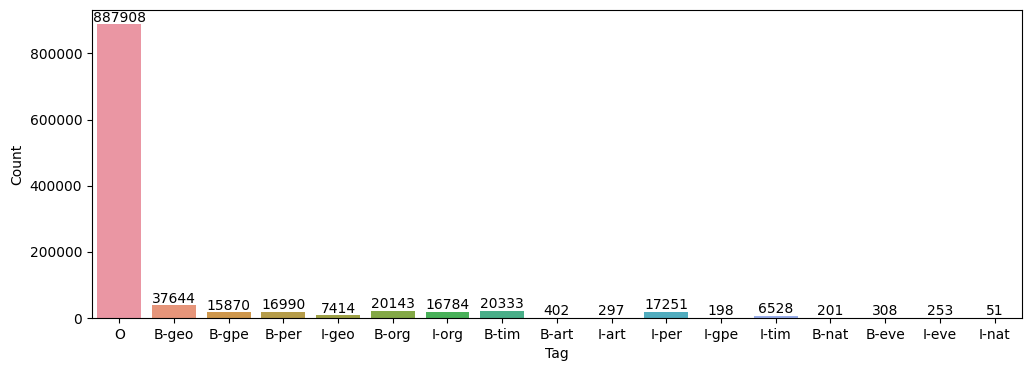

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
sns.barplot(data=tag_counts_df, x='Tag', y='Count', ax=ax)

# Annotate the counts on top of each bar
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Display height of each bar
        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position at the top center of each bar
        ha='center',  # Center align horizontally
        va='bottom'  # Align text slightly above the bar
    )

# Show the plot
plt.show()

In [13]:
tag2id = {
    "O": 0,
    "B-geo": 1,
    "B-gpe": 2,
    "B-per": 3,
    "I-geo": 4,
    "B-org": 5,
    "I-org": 6,
    "B-tim": 7,
    "B-art": 8,
    "I-art": 9,
    "I-per": 10,
    "I-gpe": 11,
    "I-tim": 12,
    "B-nat": 13,
    "I-eve": 14,
    "B-eve": 15,
    "I-nat": 16
}

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


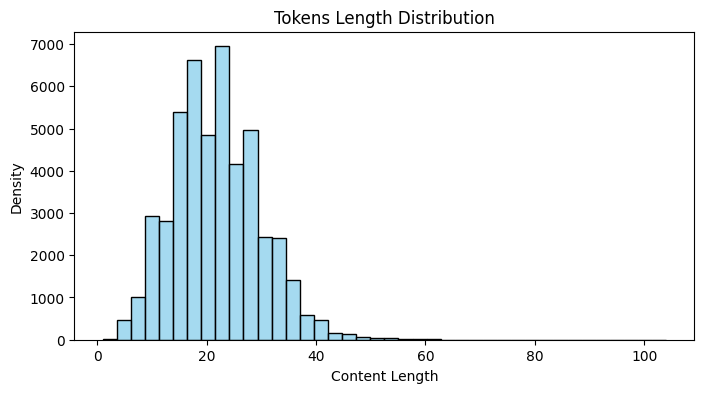

In [14]:
# Calculate the lengths of the content
lengths = [len(e) for e in df[TEXT].str.split(" ").values]

# Plotting with Seaborn's kdeplot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.histplot(lengths, ax=ax, color='skyblue', fill=True, bins=40)
ax.set_xlabel('Content Length')
ax.set_ylabel('Density')
ax.set_title('Tokens Length Distribution')

plt.show()

# Modeling (RoBERTa)

## Tokenizer

In [15]:
import transformers

In [16]:
MODEL = 'roberta-base'

In [17]:
from transformers import RobertaTokenizerFast

In [18]:
tokenizer = RobertaTokenizerFast.from_pretrained(
    pretrained_model_name_or_path=MODEL,
    add_prefix_space=True,
    clean_up_tokenization_spaces=True
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [19]:
# Token lengths calculation
token_lens = []
for sentence in df[TEXT]:
    tokens = tokenizer.encode(text=sentence, truncation=True, max_length=512)
    token_lens.append(len(tokens))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


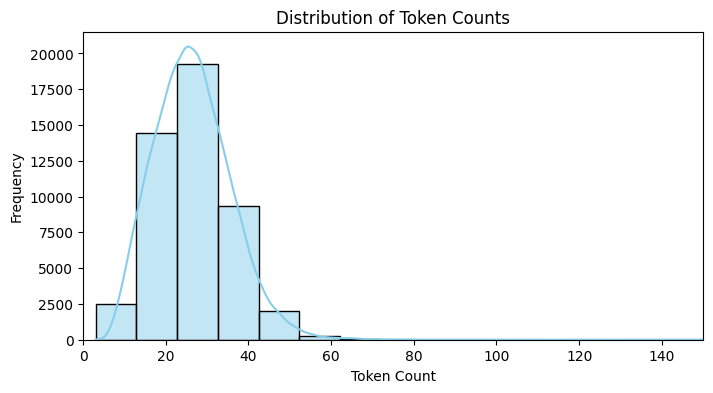

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_size_inches(8, 4)
sns.histplot(token_lens, bins=15, kde=True, color='skyblue', ax=ax)
ax.set_xlim([0, 150])
ax.set_xlabel('Token Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Token Counts')
plt.show()

In [21]:
MAX_LEN = 60

In [22]:
example = df[TEXT][0]
tokenized_input = tokenizer(example, is_split_into_words=False)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [23]:
print(tokenized_input.keys())

dict_keys(['input_ids', 'attention_mask'])


In [24]:
print(tokens)

['<s>', 'ĠThousands', 'Ġof', 'Ġdemonstrators', 'Ġhave', 'Ġmarched', 'Ġthrough', 'ĠLondon', 'Ġto', 'Ġprotest', 'Ġthe', 'Ġwar', 'Ġin', 'ĠIraq', 'Ġand', 'Ġdemand', 'Ġthe', 'Ġwithdrawal', 'Ġof', 'ĠBritish', 'Ġtroops', 'Ġfrom', 'Ġthat', 'Ġcountry', 'Ġ.', '</s>']


## Dataset Utility Class

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader

In [26]:
BATCH_SIZE = 64

In [27]:
examples = df[TEXT].head().to_list()

In [28]:
class NERDataset(Dataset):
    def __init__(self, sentences, ner_tags, tokenizer, max_len, tag2id, label_pad_token_id=-100, include_raw_text=False):
        self.sentences = sentences
        self.ner_tags = ner_tags
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tag2id = tag2id
        self.label_pad_token_id = label_pad_token_id
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.sentences)

    def align_labels(self, labels, word_ids):
        aligned_labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(self.label_pad_token_id)
            elif word_idx != previous_word_idx:
                aligned_labels.append(labels[word_idx])
            else:
                aligned_labels.append(self.label_pad_token_id)
            previous_word_idx = word_idx

        # Ensure aligned_labels matches max_len with padding if needed
        aligned_labels = aligned_labels[:self.max_len] + \
                         [self.label_pad_token_id] * (self.max_len - len(aligned_labels))
        
        return aligned_labels

    def __getitem__(self, item):
        # Tokenize sentence and prepare labels
        sentence_tokens = self.sentences[item].split(" ")
        sentence_labels = [self.tag2id[label] for label in eval(self.ner_tags[item])]

        encoding = self.tokenizer(
            sentence_tokens,
            is_split_into_words=True,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        word_ids = encoding.word_ids()  # Word IDs for alignment
        aligned_labels = self.align_labels(sentence_labels, word_ids)

        # Convert aligned labels to tensor
        aligned_labels = torch.tensor(aligned_labels, dtype=torch.long)

        # Prepare output dictionary
        output = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': aligned_labels
        }

        if self.include_raw_text:
            output['sentence_text'] = sentence_tokens

        return output

    def collate_fn(self, batch):
        # Collate function for DataLoader to handle padding dynamically
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])

        batch_output = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

        if self.include_raw_text:
            batch_output['sentence_text'] = [item['sentence_text'] for item in batch]

        return batch_output

In [29]:
def create_data_loader(df, tokenizer, tag2id, max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False):
    dataset = NERDataset(
        sentences=df[TEXT].to_list(),
        ner_tags=df[TARGET].to_list(),
        tokenizer=tokenizer,
        tag2id=tag2id,
        max_len=max_len,
        include_raw_text=include_raw_text
    )

    return DataLoader(dataset=dataset, batch_size=batch_size, collate_fn=dataset.collate_fn)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df_train, df_val_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_STATE)

In [32]:
df_val, df_test = train_test_split(df_val_test, test_size = 0.5, random_state = RANDOM_STATE)

In [33]:
print(df_train.shape, df_val.shape, df_test.shape)

(38367, 4) (4796, 4) (4796, 4)


In [34]:
train_data_loader = create_data_loader(df_train, tokenizer, tag2id=tag2id, include_raw_text=False)
val_data_loader = create_data_loader(df_val, tokenizer, tag2id=tag2id, include_raw_text=True)
test_data_loader = create_data_loader(df_test, tokenizer, tag2id=tag2id, include_raw_text=True)

In [35]:
type(val_data_loader)

torch.utils.data.dataloader.DataLoader

In [36]:
# Testing to see if the data loader works appropriately
data = next(iter(val_data_loader))

In [37]:
# Print the keys in the batch
print("Batch Keys:", data.keys())

# Print the shape of the 'input_ids' tensor
print(f"Shape of 'input_ids' tensor: {data['input_ids'].shape} (Batch Size, Max Length)")

# Print the shape of the 'attention_mask' tensor
print(f"Shape of 'attention_mask' tensor: {data['attention_mask'].shape} (Batch Size, Max Length)")

# Print the shape of the 'targets' tensor
print(f"Shape of 'labels' tensor: {data['labels'].shape} (Batch Size)")

Batch Keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'sentence_text'])
Shape of 'input_ids' tensor: torch.Size([64, 60]) (Batch Size, Max Length)
Shape of 'attention_mask' tensor: torch.Size([64, 60]) (Batch Size, Max Length)
Shape of 'labels' tensor: torch.Size([64, 60]) (Batch Size)


## Model Utility Class

In [38]:
from transformers import RobertaModel

In [39]:
model = RobertaModel.from_pretrained(MODEL)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from torch import nn

In [41]:
class NERClassifier(nn.Module):
    def __init__(self, n_classes, model_name=MODEL):
        super(NERClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)  # n_classes for each token

    def forward(self, input_ids, attention_mask):
        # Get hidden states for each token in the sequence
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Apply dropout
        output = self.drop(sequence_output)
        
        # Apply classification layer on each token
        return self.out(output)  # Shape: (batch_size, seq_len, n_classes)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
print(device)

cuda:0


In [44]:
len(tag2id)

17

In [45]:
model = NERClassifier(n_classes=len(tag2id))
model = model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

## Training Loop Utility Functions

In [46]:
from transformers import get_linear_schedule_with_warmup
from torch import optim

In [47]:
EPOCHS = 8

In [48]:
optimizer = optim.AdamW(model.parameters(), lr= 2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(0.1 * total_steps),
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(ignore_index=-100).to(device)

In [49]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_tokens = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["labels"].to(device)  # Shape: (batch_size, seq_len)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: (batch_size, seq_len, n_classes)

        # Reshape outputs and targets for calculating token-level loss
        outputs = outputs.view(-1, outputs.shape[-1])  # Shape: (batch_size * seq_len, n_classes)
        targets = targets.view(-1)  # Shape: (batch_size * seq_len)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate accuracy at the token level
        _, preds = torch.max(outputs, dim=1)
        mask = targets != -100  # Mask out padding tokens
        correct_predictions += torch.sum(preds[mask] == targets[mask])
        total_tokens += torch.sum(mask)

        # Backpropagation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calculate mean accuracy and loss
    accuracy = correct_predictions.double() / total_tokens
    mean_loss = np.mean(losses)

    return accuracy, mean_loss

In [50]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    total_tokens = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)  # Shape: (batch_size, seq_len)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: (batch_size, seq_len, n_classes)

            # Reshape outputs and targets for calculating token-level loss
            outputs = outputs.view(-1, outputs.shape[-1])  # Shape: (batch_size * seq_len, n_classes)
            targets = targets.view(-1)  # Shape: (batch_size * seq_len)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate accuracy at the token level
            _, preds = torch.max(outputs, dim=1)
            mask = targets != -100  # Mask out padding tokens
            correct_predictions += torch.sum(preds[mask] == targets[mask])
            total_tokens += torch.sum(mask)

    # Calculate mean accuracy and loss
    accuracy = correct_predictions.double() / total_tokens
    mean_loss = np.mean(losses)

    return accuracy, mean_loss

In [51]:
from collections import defaultdict
from textwrap import wrap

Epoch 1/8
---------------
Train loss: 0.5102, accuracy: 0.8609
Val loss: 0.1151, accuracy: 0.9665
Epoch 2/8
---------------
Train loss: 0.1045, accuracy: 0.9686
Val loss: 0.0983, accuracy: 0.9703
Validation loss improved. Saving model with val_loss: 0.0983
Epoch 3/8
---------------
Train loss: 0.0872, accuracy: 0.9724
Val loss: 0.0952, accuracy: 0.9709
Validation loss improved. Saving model with val_loss: 0.0952
Epoch 4/8
---------------
Train loss: 0.0765, accuracy: 0.9754
Val loss: 0.0946, accuracy: 0.9718
Epoch 5/8
---------------
Train loss: 0.0682, accuracy: 0.9777
Val loss: 0.0961, accuracy: 0.9721
Early stopping triggered. No significant improvement in validation loss for 2 epochs.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

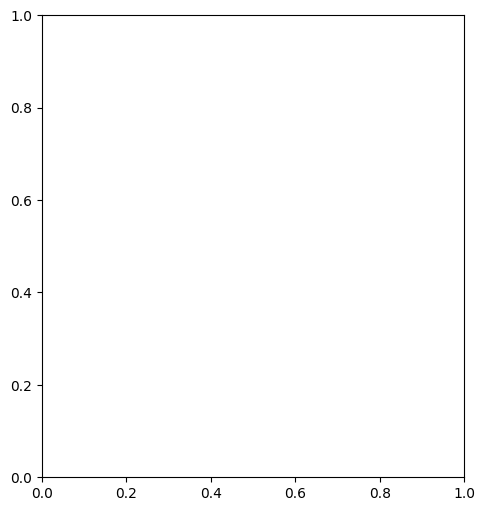

In [52]:
PATIENCE = 2  # Number of epochs to wait for improvement
epochs_no_improve = 0
IMPROVEMENT_THRESHOLD = 0.01  # Minimum improvement of 1% in validation loss

history = defaultdict(list)
best_val_loss = None  # Initialize best_val_loss as None

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 15)
    
    # Training step
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
    
    # Validation step
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')
    
    # Record training history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Initialize best_val_loss after the first validation step
    if best_val_loss is None:
        best_val_loss = val_loss  # Set the first val_loss as the baseline best loss
    
    # Check if validation loss improved by at least the threshold percentage
    if val_loss < best_val_loss * (1 - IMPROVEMENT_THRESHOLD):
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_state.bin')  # Save the best model
        print(f"Validation loss improved. Saving model with val_loss: {val_loss:.4f}")
    else:
        epochs_no_improve += 1
    
    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered. No significant improvement in validation loss for {PATIENCE} epochs.")
        break

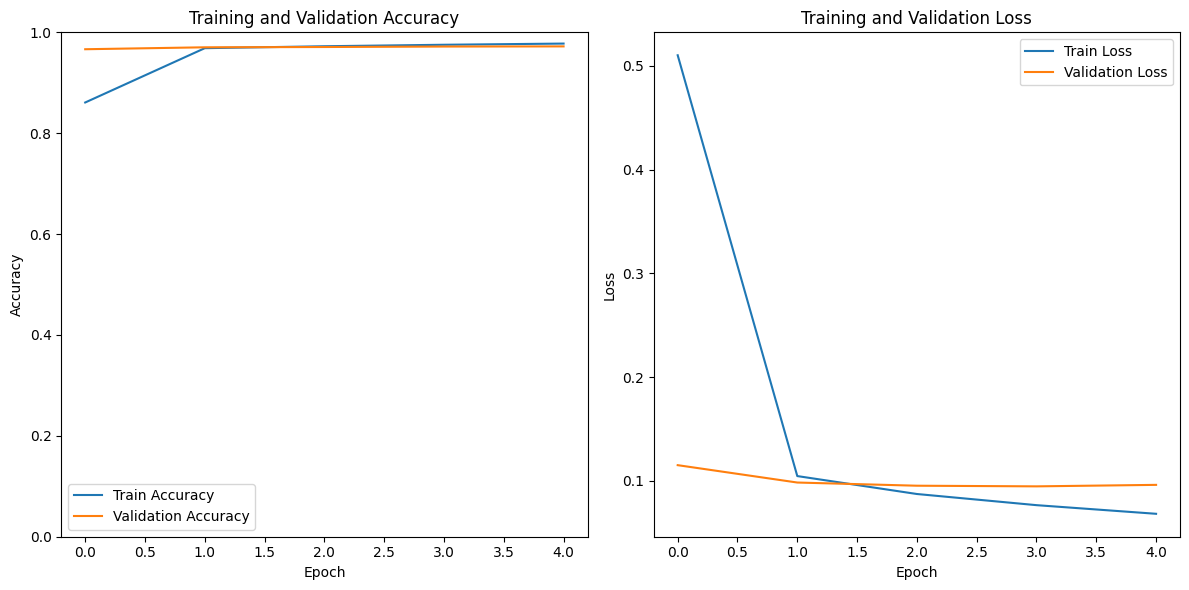

In [56]:
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot([acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in history['train_acc']], label='Train Accuracy')
plt.plot([acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in history['val_acc']], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot([loss.cpu().numpy() if hasattr(loss, 'cpu') else loss for loss in history['train_loss']], label='Train Loss')
plt.plot([loss.cpu().numpy() if hasattr(loss, 'cpu') else loss for loss in history['val_loss']], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
# Evaluate the model on the test set
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

Test Accuracy: 0.9722, Test Loss: 0.0911


## Model Evaluation

In [76]:
import torch.nn.functional as F

def get_predictions(model, data_loader, device):
    model = model.eval()
    sentence_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            # Retrieve necessary data from batch
            texts = d['sentence_text']  # This is the list of original tokens for each sentence
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)  # Shape: (batch_size, seq_len)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: (batch_size, seq_len, n_classes)

            # Get token-level predictions
            _, preds = torch.max(outputs, dim=2)  # preds shape: (batch_size, seq_len)

            # Calculate softmax probabilities if needed
            probs = F.softmax(outputs, dim=2)  # probs shape: (batch_size, seq_len, n_classes)

            # Append results
            sentence_texts.extend(texts)  # Extend by list of lists
            predictions.extend(preds.cpu())  # Store predictions as lists
            prediction_probs.extend(probs.cpu())  # Store probabilities as lists
            real_values.extend(targets.cpu())  # Store true labels as lists

    # Convert to tensors if needed
    predictions = torch.stack(predictions)  # Shape: (total_sentences, seq_len)
    prediction_probs = torch.stack(prediction_probs)  # Shape: (total_sentences, seq_len, n_classes)
    real_values = torch.stack(real_values)  # Shape: (total_sentences, seq_len)

    return sentence_texts, predictions, prediction_probs, real_values

In [84]:
def show_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(14, 10))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('NER Confusion Matrix')
    plt.show()

In [85]:
from sklearn.metrics import classification_report

In [86]:
# Get token-level predictions and true labels
y_tweets_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader, device)

# Flatten predictions and true labels, ignoring padding tokens (-100)
y_pred_flat = y_pred.view(-1)  # Flatten predictions
y_test_flat = y_test.view(-1)  # Flatten true labels

# Create a mask to filter out padding tokens
mask = y_test_flat != -100
y_pred_flat = y_pred_flat[mask]
y_test_flat = y_test_flat[mask]

# Generate the classification report
print(classification_report(y_test_flat, y_pred_flat, target_names=list(tag2id.keys())))

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     88088
       B-geo       0.87      0.91      0.89      3788
       B-gpe       0.96      0.95      0.95      1583
       B-per       0.84      0.85      0.85      1738
       I-geo       0.82      0.82      0.82       711
       B-org       0.80      0.73      0.76      1971
       I-org       0.85      0.77      0.81      1692
       B-tim       0.90      0.89      0.90      1980
       B-art       0.60      0.09      0.15        35
       I-art       0.00      0.00      0.00        23
       I-per       0.86      0.91      0.88      1802
       I-gpe       0.90      0.75      0.82        12
       I-tim       0.80      0.81      0.80       612
       B-nat       0.70      0.33      0.45        21
       I-eve       0.33      0.20      0.25        25
       B-eve       0.53      0.31      0.39        26
       I-nat       0.00      0.00      0.00         6

    accuracy              

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
from sklearn.metrics import confusion_matrix

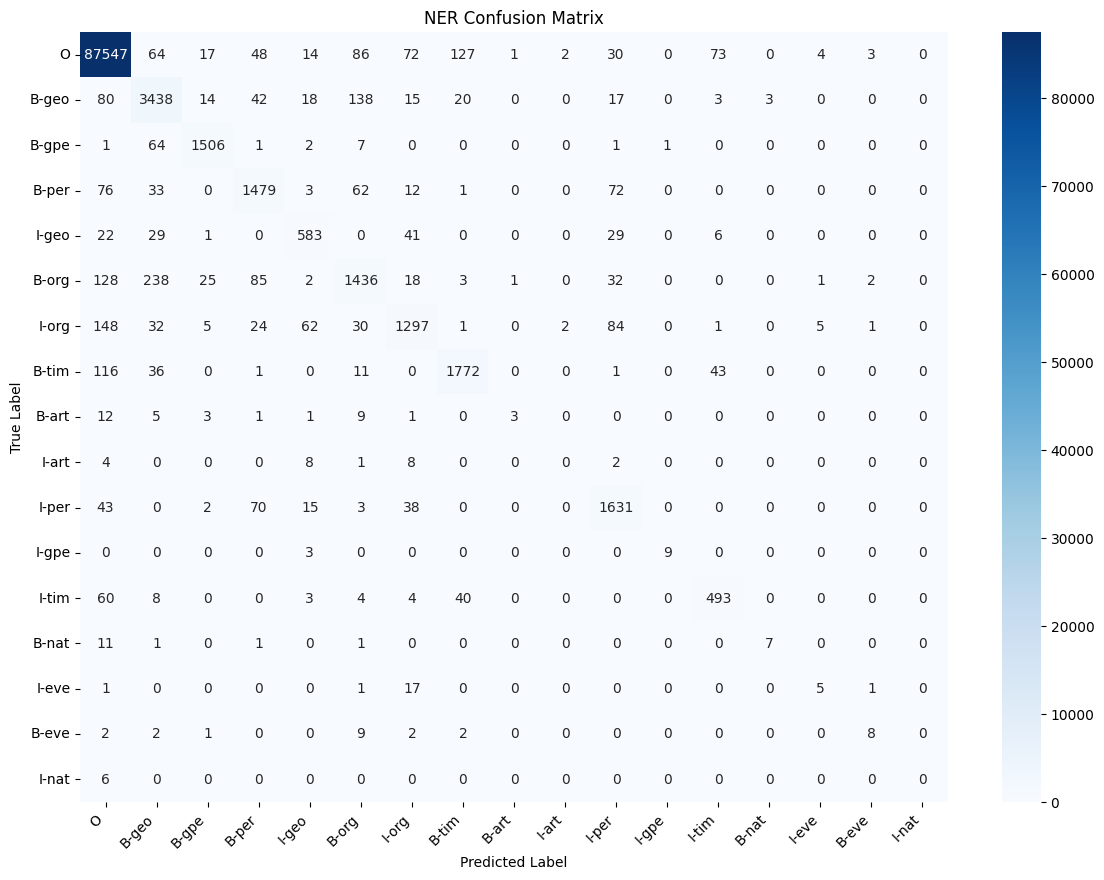

In [88]:
# Flatten predictions and true labels, ignoring padding tokens (-100)
y_pred_flat = y_pred.view(-1)  # Flatten predictions
y_test_flat = y_test.view(-1)  # Flatten true labels

# Create a mask to filter out padding tokens
mask = y_test_flat != -100
y_pred_flat = y_pred_flat[mask]
y_test_flat = y_test_flat[mask]

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Convert to DataFrame for better visualization with class names
df_cm = pd.DataFrame(cm, index=list(tag2id.keys()), columns=list(tag2id.keys()))

# Display the confusion matrix
show_confusion_matrix(df_cm, list(tag2id.keys()))